In [19]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import cv2 as cv
from pathlib import Path
import random
from shutil import copyfile, rmtree
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [20]:
softmax = torch.nn.Softmax(dim=1)
device = torch.device("cuda")
device

device(type='cuda')

# Basic data loader

In [68]:
def load_train_data(input_dir, newSize=(64,64)):
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255#normalizacja
                train_img.append(img)
        categories_count.append(count)

    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [70]:
def load_test_data(input_dir, newSize=(64,64)):
    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    #with labels_path.open("r", encoding ="utf-8") as f:
    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    #print(objects)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            #print(count)
            #print(c)
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)



    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        test_img.append(img)
        labels.append(e['value'])


    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [71]:
torch.cuda.empty_cache() 

In [75]:
data_size = int(224/2)

data_train = load_train_data("train_test_sw/train_sw",newSize=(data_size,data_size))
X_train = data_train['values']
y_train = data_train['labels']


data_test = load_test_data("train_test_sw/test_sw",newSize=(data_size,data_size))
X_test = data_test['values']
y_test = data_test['labels']

class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)
y_test_enc = class_le.fit_transform(y_test)

X_train = X_train[...,:3]
X_test = X_test[...,:3]

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

number_of_features = X_train.shape[1]
number_of_classes = 5
batch_size = 32

# Model infrastructure

In [25]:
class VGG(nn.Module):
    def __init__(
        self, features: nn.Module, num_classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
    ) -> None:
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [26]:
class VGG16(nn.Module):
    def __init__(
        self, num_classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
    ) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [27]:
from torch.utils.data import Dataset


class CustomTensorDataset(Dataset):
    def __init__(self, tensors):
        self.tensors = tensors

    def __getitem__(self, index):
        x = self.tensors[0][index]
        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].shape[0]

In [28]:
X_train.shape

(1027, 3, 112, 112)

# Model parameters

In [29]:
# batch_size = 16

dataset = CustomTensorDataset((X_train, y_train_enc))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = CustomTensorDataset((X_test, y_test_enc))
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [30]:
model = VGG16().to(device=device)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

In [31]:
costs = []
train_acc = []
test_acc = []

In [32]:
X_test.shape

(259, 3, 112, 112)

## Train & test functions

In [33]:
test_acc = []
 
def test(epoch):
  model.eval()
  correct=0
  total=0

  with torch.no_grad():
    for i, (imgs, labels) in enumerate(test_dataloader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs.float())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
      del imgs, labels, outputs
  acc = correct/total
  test_acc.append(acc)
 
  print('Test Accuracy: %.3f'%(acc))

  return acc

In [34]:
train_acc = []
train_loss = []

def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0

  for i, (imgs, labels) in enumerate(dataloader):
    #move tensors to device
    imgs = imgs.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(imgs.float())
    loss = criterion(outputs, labels)

    #Bacward & opt
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    #
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  loss = running_loss/len(dataloader)
  acc = correct/total

  train_acc.append(acc)
  train_loss.append(loss)
  print('Train Accuracy: %.3f | Loss: %.3f'%(acc, loss))

  scheduler.step()

  return acc, loss

## Model training without augmentation

In [35]:
total_step = len(dataloader)

vgg_train_acc = []
vgg_train_loss = []
vgg_test_acc = []

for epoch in range(100):
    tr_acc, tr_loss = train(epoch)
    vgg_test_acc.append(test(epoch))
    vgg_train_acc.append(tr_acc)
    vgg_train_loss.append(tr_loss)


Epoch : 0
Train Accuracy: 0.182 | Loss: 10.280
Test Accuracy: 0.202

Epoch : 1
Train Accuracy: 0.226 | Loss: 1.875
Test Accuracy: 0.203

Epoch : 2
Train Accuracy: 0.259 | Loss: 1.614
Test Accuracy: 0.301

Epoch : 3
Train Accuracy: 0.350 | Loss: 1.495
Test Accuracy: 0.438

Epoch : 4
Train Accuracy: 0.438 | Loss: 1.298
Test Accuracy: 0.411

Epoch : 5
Train Accuracy: 0.478 | Loss: 1.181
Test Accuracy: 0.551

Epoch : 6
Train Accuracy: 0.513 | Loss: 1.077
Test Accuracy: 0.610

Epoch : 7
Train Accuracy: 0.558 | Loss: 1.002
Test Accuracy: 0.589

Epoch : 8
Train Accuracy: 0.573 | Loss: 0.934
Test Accuracy: 0.640

Epoch : 9
Train Accuracy: 0.629 | Loss: 0.880
Test Accuracy: 0.660

Epoch : 10
Train Accuracy: 0.603 | Loss: 1.026
Test Accuracy: 0.562

Epoch : 11
Train Accuracy: 0.616 | Loss: 1.018
Test Accuracy: 0.604

Epoch : 12
Train Accuracy: 0.673 | Loss: 0.784
Test Accuracy: 0.735

Epoch : 13
Train Accuracy: 0.707 | Loss: 0.669
Test Accuracy: 0.758

Epoch : 14
Train Accuracy: 0.668 | Loss: 0

In [36]:
torch.save(model.state_dict(), "./model_params/vgg16")

## Model accuracy without augmentation

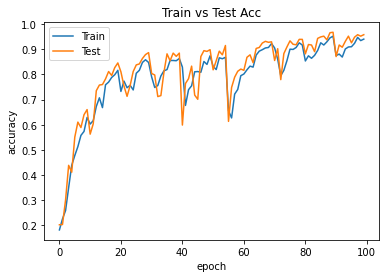

In [37]:
plt.plot(vgg_train_acc)
plt.plot(vgg_test_acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Test"])
plt.title("Train vs Test Acc")

plt.show()

## Model loss without augmentation

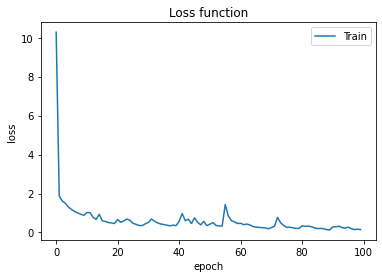

In [38]:
plt.plot(vgg_train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train"])
plt.title("Loss function")

plt.show()

# Data loader with augmentation

In [172]:
def load_aug_train_data(input_dir, newSize=(64,64)):
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255#normalizacja
                #rotating image
                h, w = img.shape[:2]
                r_matrix = cv.getRotationMatrix2D((w/2,h/2),45,.5)
                img = cv.warpAffine(img, r_matrix, (w,h))
                #augmenting brughtness
                b = np.ones(img.shape, dtype=np.float64) * 70/255
                # print(type(img[0][0][0]), type(b))
                img = cv.add(img, b)
                train_img.append(img)
        categories_count.append(count)

    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [173]:
def load_aug_test_data(input_dir, newSize=(64,64)):
    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    #with labels_path.open("r", encoding ="utf-8") as f:
    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    #print(objects)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            #print(count)
            #print(c)
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)



    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        #rotating image
        h, w = img.shape[:2]
        r_matrix = cv.getRotationMatrix2D((w/2,h/2),45,.5)
        img = cv.warpAffine(img, r_matrix, (w,h))
        #augmenting brughtness
        b = np.ones(img.shape, dtype=np.float64) * 70/255
        img = cv.add(img, b)
        test_img.append(img)
        labels.append(e['value'])


    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [174]:
data_size = int(224/2)

data_train = load_aug_train_data("train_test_sw/train_sw",newSize=(data_size,data_size))
X_train = data_train['values']
y_train = data_train['labels']


data_test = load_aug_test_data("train_test_sw/test_sw",newSize=(data_size,data_size))
X_test = data_test['values']
y_test = data_test['labels']

class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)
y_test_enc = class_le.fit_transform(y_test)

X_train = X_train[...,:3]
X_test = X_test[...,:3]

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

number_of_features = X_train.shape[1]
number_of_classes = 5
batch_size = 32

# Visual data comparision

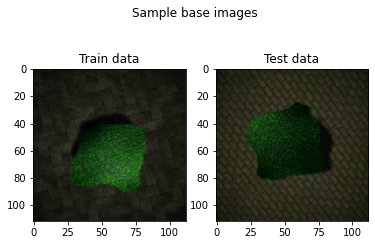

In [80]:
from PIL import Image
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sample base images')

X_train[0][0].shape
ax1.set_title('Train data')
ax1.imshow(np.dstack((X_train[0][0], X_train[0][1], X_train[0][2])))
ax2.set_title('Test data')
ax2.imshow(np.dstack((X_test[0][0], X_test[0][1], X_test[0][2])))
plt.show()

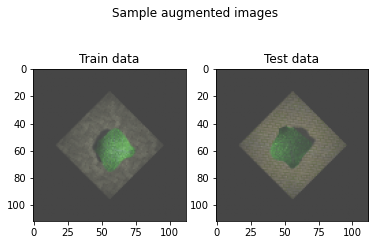

In [177]:
from PIL import Image
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sample augmented images')

X_train[0][0].shape
ax1.set_title('Train data')
ax1.imshow(np.dstack((X_train[0][0], X_train[0][1], X_train[0][2])))
ax2.set_title('Test data')
ax2.imshow(np.dstack((X_test[0][0], X_test[0][1], X_test[0][2])))
plt.show()

In [178]:
X_train.shape

(1027, 3, 112, 112)

## Model training with augmentation

In [182]:
model = VGG16().to(device=device)
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

In [191]:
total_step = len(dataloader)

vgg_aug_train_acc = []
vgg_aug_train_loss = []
vgg_aug_test_acc = []

for epoch in range(100):
    tr_aug_acc, tr_aug_loss = train(epoch)
    vgg_aug_test_acc.append(test(epoch))
    vgg_aug_train_acc.append(tr_aug_acc)
    vgg_aug_train_loss.append(tr_aug_loss)


Epoch : 0
Train Accuracy: 0.907 | Loss: 0.292
Test Accuracy: 0.729

Epoch : 1
Train Accuracy: 0.903 | Loss: 0.336
Test Accuracy: 0.883

Epoch : 2
Train Accuracy: 0.939 | Loss: 0.212
Test Accuracy: 0.732

Epoch : 3
Train Accuracy: 0.927 | Loss: 0.220
Test Accuracy: 0.946

Epoch : 4
Train Accuracy: 0.940 | Loss: 0.195
Test Accuracy: 0.896

Epoch : 5
Train Accuracy: 0.952 | Loss: 0.132
Test Accuracy: 0.890

Epoch : 6
Train Accuracy: 0.960 | Loss: 0.113
Test Accuracy: 0.871

Epoch : 7
Train Accuracy: 0.971 | Loss: 0.080
Test Accuracy: 0.941

Epoch : 8
Train Accuracy: 0.976 | Loss: 0.071
Test Accuracy: 0.985

Epoch : 9
Train Accuracy: 0.979 | Loss: 0.071
Test Accuracy: 0.979

Epoch : 10
Train Accuracy: 0.948 | Loss: 0.157
Test Accuracy: 0.967

Epoch : 11
Train Accuracy: 0.961 | Loss: 0.103
Test Accuracy: 0.948

Epoch : 12
Train Accuracy: 0.910 | Loss: 0.253
Test Accuracy: 0.931

Epoch : 13
Train Accuracy: 0.956 | Loss: 0.127
Test Accuracy: 0.945

Epoch : 14
Train Accuracy: 0.953 | Loss: 0.

## Model accuracy with augmentation

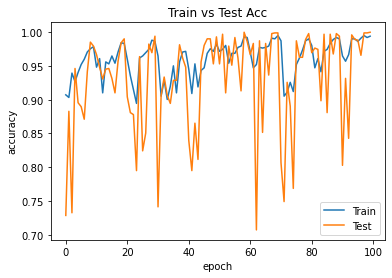

In [192]:
plt.plot(vgg_aug_train_acc)
plt.plot(vgg_aug_test_acc)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Train", "Test"])
plt.title("Train vs Test Acc")

plt.show()

## Model loss with augmentation

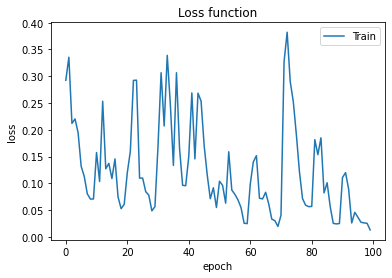

In [193]:
plt.plot(vgg_aug_train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train"])
plt.title("Loss function")

plt.show()

# Accuracy & loss comparision

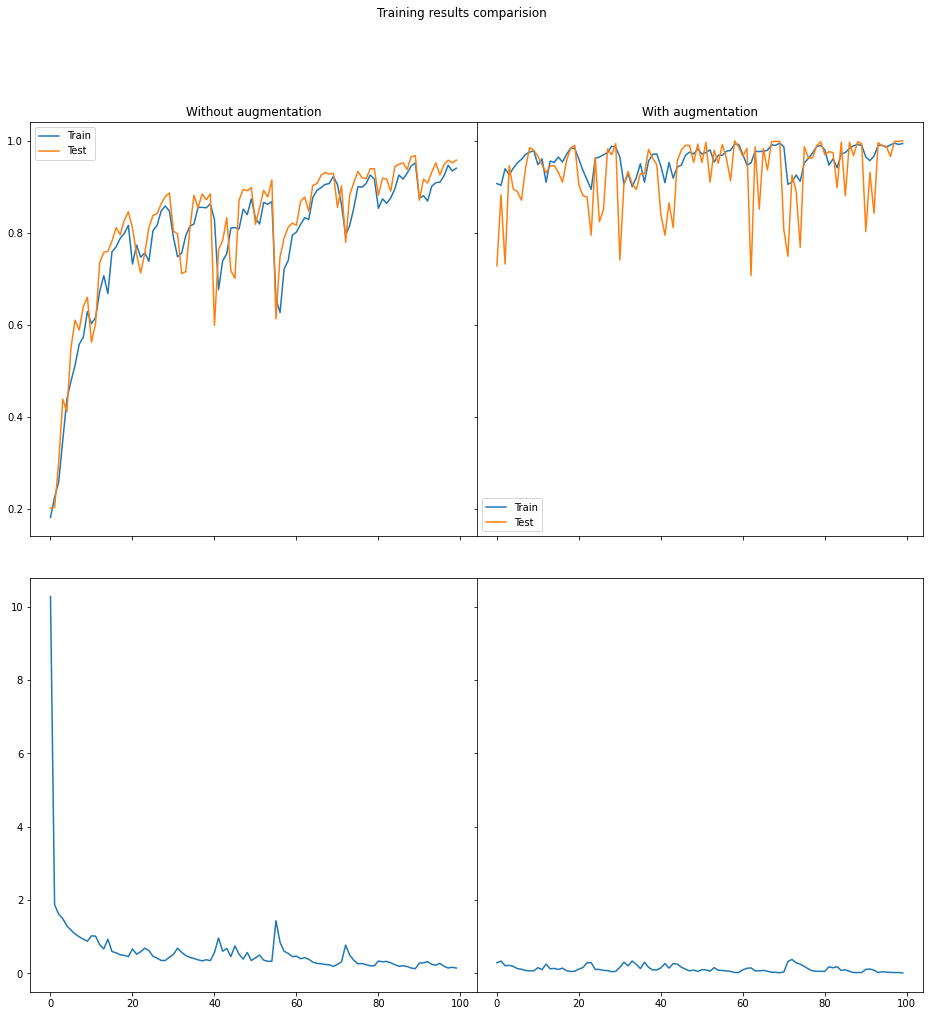

In [199]:
fig = plt.figure(figsize=(16,16))
gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0)
ax = gs.subplots(sharex=True, sharey='row')

# ax[0][0], ax[0][1] = 

fig.suptitle('Training results comparision')
#column titles
ax[0][0].set_title('Without augmentation')
ax[0][1].set_title('With augmentation')
#Acc without aug
ax[0][0].plot(vgg_train_acc)
ax[0][0].plot(vgg_test_acc)
ax[0][0].legend(["Train", "Test"])

#Acc with aug
ax[0][1].plot(vgg_aug_train_acc)
ax[0][1].plot(vgg_aug_test_acc)
ax[0][1].legend(["Train", "Test"])

#Loss without aug
ax[1][0].plot(vgg_train_loss)

#Loss with aug
ax[1][1].plot(vgg_aug_train_loss)

plt.show()

## Wnioski 
 - Zadana metoda augmentacji w sposób zauważalny poprawiła jakość i szybkość trenowania modelu. 
 - Zmniejszyła ona czas potrzebny na osiągnięcie Acc na poziommie zarówno 80%, jak i 90%.
 - Dla modelu uczącego się na zaugmentowanych danych znacznie szybciej osiągany jest najniższy pułap funkcji straty.